# JPEG Double Compression Detection

In this notebook, we train and evaluate our proposed CNN detector to determine whether an image is
uncompressed, single, or double compressed.

## Acknowledgements
Our model is based on Park et al.'s model in the paper: https://openaccess.thecvf.com/content_ECCV_2018/papers/Jin-Seok_Park_Double_JPEG_Detection_ECCV_2018_paper.pdf

We make the model smaller, remove the JPEG quantization table requirement, and modify the network to also detect no JPEG compression.

## Prepare Dataset

Import required libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
import random
from sklearn.model_selection import train_test_split
from google.colab import drive

# Mount Google Drive and set default path
drive.mount('/content/drive')

# IMPORTANT: Change this to your own path, ending with "dataset/"
PATH = '/content/drive/MyDrive/dataset/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Set random seed

In [2]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

Get training dataset (image partitions derived from the first 200 images of the dataset)

In [3]:
# Uncompressed images
X_1 = np.load(PATH + f"detector_npy/njpeg/noblockcnn200.npy")
X_1 = np.concatenate((X_1, X_1, X_1, X_1, X_1))

# Single compressed images
X_2 = np.load(PATH + f"detector_npy/sjpeg10/singleblockcnn200.npy")
X_2 = np.concatenate(
    (X_2, np.load(PATH + f"detector_npy/sjpeg30/singleblockcnn200.npy")))
X_2 = np.concatenate(
    (X_2, np.load(PATH + f"detector_npy/sjpeg50/singleblockcnn200.npy")))
X_2 = np.concatenate(
    (X_2, np.load(PATH + f"detector_npy/sjpeg70/singleblockcnn200.npy")))
X_2 = np.concatenate(
    (X_2, np.load(PATH + f"detector_npy/sjpeg90/singleblockcnn200.npy")))

# Double compressed images
X_3 = np.load(PATH + f"detector_npy/djpeg5010/doubleblockcnn200.npy")
X_3 = np.concatenate(
    (X_3, np.load(PATH + f"detector_npy/djpeg5030/doubleblockcnn200.npy")))
X_3 = np.concatenate(
    (X_3, np.load(PATH + f"detector_npy/djpeg5050/doubleblockcnn200.npy")))
X_3 = np.concatenate(
    (X_3, np.load(PATH + f"detector_npy/djpeg5070/doubleblockcnn200.npy")))
X_3 = np.concatenate(
    (X_3, np.load(PATH + f"detector_npy/djpeg5090/doubleblockcnn200.npy")))

# Labels
mapping = ["Uncompressed", "Single compression", "Double compression"]
y = np.array([0] * len(X_1) + [1] * len(X_2) + [2] * len(X_3))

X = np.concatenate((X_1, X_2))
del X_1, X_2
X = np.concatenate((X, X_3))
del X_3

Get dataset training and validation data

In [4]:
y_train, y_val, X_train, X_val = train_test_split(
    y, X, test_size=0.25, random_state=seed)
    
del X, y

In [5]:
print(y_val.shape, X_val.shape, y_train.shape, X_train.shape)
print(mapping)

(157583,) (157583, 120, 64, 1) (472747,) (472747, 120, 64, 1)
['Uncompressed', 'Single compression', 'Double compression']


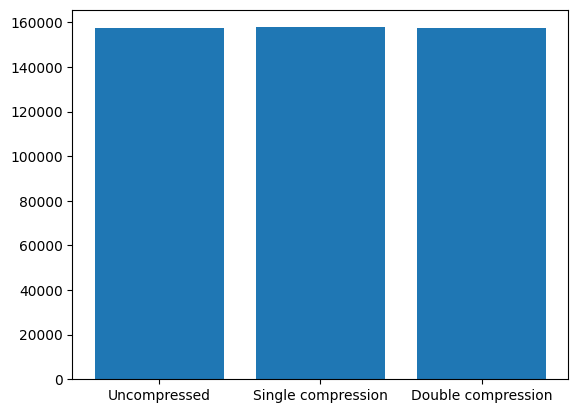

In [6]:
# Want to ensure that the training data is balanced
frequency = np.bincount(y_train)
plt.bar(mapping, frequency)
plt.show()

## Prepare the CNN

Define model

In [7]:
# Create CNN model
wd = 1e-5
rate = 0.1

model = Sequential([

    # Block 1
    Conv2D(64, kernel_regularizer=regularizers.l2(wd), kernel_size=5,
           activation='relu', input_shape=(120, 64, 1)),
    BatchNormalization(),
    Conv2D(64, kernel_regularizer=regularizers.l2(wd), kernel_size=5,
           activation='relu'),
    BatchNormalization(),
    MaxPool2D((2, 2)),

    # Block 2
    Conv2D(128, kernel_regularizer=regularizers.l2(wd), kernel_size=5,
           activation='relu'),
    BatchNormalization(),
    MaxPool2D((2, 2)),

    # Block 3
    Conv2D(256, kernel_regularizer=regularizers.l2(wd), kernel_size=5,
           activation='relu'),
    BatchNormalization(),
    MaxPool2D((2, 2)),

    # Dense output
    Flatten(),
    BatchNormalization(),
    Dense(3, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 116, 60, 64)       1664      
                                                                 
 batch_normalization (BatchN  (None, 116, 60, 64)      256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 56, 64)       102464    
                                                                 
 batch_normalization_1 (Batc  (None, 112, 56, 64)      256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 56, 28, 64)       0         
 )                                                               
                                                        

Compile model

In [8]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4), # Found that default learning rate is too large
    loss='sparse_categorical_crossentropy',
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)

## Train the CNN

Model training stops when it stops improving for 10 epochs or at the 60th epoch. The best model is saved, based on validation data.

In [9]:
# Train model with early stopping and model checkpoint callbacks
history = model.fit(
    X_train,
    y_train,
    epochs=60,
    batch_size=512,
    validation_data=(X_val, y_val),
    verbose=1,
    callbacks=[
        EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=20),
        ModelCheckpoint(
            filepath='CNNmodel', monitor='val_sparse_categorical_accuracy', save_best_only=True)
    ]
)

Epoch 1/60
924/924 [==============================] - ETA: 0s - loss: 0.3072 - sparse_categorical_accuracy: 0.8249

924/924 [==============================] - 126s 116ms/step - loss: 0.3072 - sparse_categorical_accuracy: 0.8249 - val_loss: 0.3402 - val_sparse_categorical_accuracy: 0.8182
Epoch 2/60
923/924 [============================>.] - ETA: 0s - loss: 0.2737 - sparse_categorical_accuracy: 0.8375

924/924 [==============================] - 96s 104ms/step - loss: 0.2737 - sparse_categorical_accuracy: 0.8375 - val_loss: 0.4095 - val_sparse_categorical_accuracy: 0.8187
Epoch 3/60
923/924 [============================>.] - ETA: 0s - loss: 0.2616 - sparse_categorical_accuracy: 0.8437

924/924 [==============================] - 96s 104ms/step - loss: 0.2617 - sparse_categorical_accuracy: 0.8437 - val_loss: 0.3573 - val_sparse_categorical_accuracy: 0.8299
Epoch 4/60
923/924 [============================>.] - ETA: 0s - loss: 0.2530 - sparse_categorical_accuracy: 0.8476

924/924 [==============================] - 96s 104ms/step - loss: 0.2530 - sparse_categorical_accuracy: 0.8476 - val_loss: 0.2757 - val_sparse_categorical_accuracy: 0.8448
Epoch 5/60
924/924 [==============================] - 93s 101ms/step - loss: 0.2483 - sparse_categorical_accuracy: 0.8506 - val_loss: 0.5941 - val_sparse_categorical_accuracy: 0.8245
Epoch 6/60
924/924 [==============================] - 94s 101ms/step - loss: 0.2424 - sparse_categorical_accuracy: 0.8529 - val_loss: 0.3997 - val_sparse_categorical_accuracy: 0.8236
Epoch 7/60
924/924 [==============================] - 94s 101ms/step - loss: 0.2373 - sparse_categorical_accuracy: 0.8559 - val_loss: 0.4658 - val_sparse_categorical_accuracy: 0.8184
Epoch 8/60
923/924 [============================>.] - ETA: 0s - loss: 0.2342 - sparse_categorical_accuracy: 0.8573

924/924 [==============================] - 96s 104ms/step - loss: 0.2342 - sparse_categorical_accuracy: 0.8573 - val_loss: 0.3241 - val_sparse_categorical_accuracy: 0.8474
Epoch 9/60
923/924 [============================>.] - ETA: 0s - loss: 0.2309 - sparse_categorical_accuracy: 0.8587

924/924 [==============================] - 96s 104ms/step - loss: 0.2309 - sparse_categorical_accuracy: 0.8587 - val_loss: 0.3071 - val_sparse_categorical_accuracy: 0.8509
Epoch 10/60
924/924 [==============================] - 94s 101ms/step - loss: 0.2284 - sparse_categorical_accuracy: 0.8605 - val_loss: 0.2899 - val_sparse_categorical_accuracy: 0.8450
Epoch 11/60
924/924 [==============================] - 93s 101ms/step - loss: 0.2274 - sparse_categorical_accuracy: 0.8614 - val_loss: 0.3196 - val_sparse_categorical_accuracy: 0.8459
Epoch 12/60
924/924 [==============================] - 94s 101ms/step - loss: 0.2241 - sparse_categorical_accuracy: 0.8629 - val_loss: 0.2574 - val_sparse_categorical_accuracy: 0.8508
Epoch 13/60
924/924 [==============================] - 93s 101ms/step - loss: 0.2223 - sparse_categorical_accuracy: 0.8637 - val_loss: 1.4578 - val_sparse_categorical_accuracy: 0.7320
Epoch 14/60
924/924 [==============================] - 93s 101ms/step - loss: 0.2205 - spars

924/924 [==============================] - 96s 104ms/step - loss: 0.2140 - sparse_categorical_accuracy: 0.8685 - val_loss: 0.2536 - val_sparse_categorical_accuracy: 0.8554
Epoch 19/60
924/924 [==============================] - 94s 101ms/step - loss: 0.2126 - sparse_categorical_accuracy: 0.8694 - val_loss: 0.3013 - val_sparse_categorical_accuracy: 0.8502
Epoch 20/60
924/924 [==============================] - 94s 101ms/step - loss: 0.2112 - sparse_categorical_accuracy: 0.8699 - val_loss: 0.3166 - val_sparse_categorical_accuracy: 0.8437
Epoch 21/60
923/924 [============================>.] - ETA: 0s - loss: 0.2095 - sparse_categorical_accuracy: 0.8711

924/924 [==============================] - 96s 104ms/step - loss: 0.2096 - sparse_categorical_accuracy: 0.8711 - val_loss: 0.2438 - val_sparse_categorical_accuracy: 0.8565
Epoch 22/60
924/924 [==============================] - 94s 101ms/step - loss: 0.2085 - sparse_categorical_accuracy: 0.8721 - val_loss: 0.5042 - val_sparse_categorical_accuracy: 0.8368
Epoch 23/60
924/924 [==============================] - 94s 101ms/step - loss: 0.2080 - sparse_categorical_accuracy: 0.8727 - val_loss: 0.9022 - val_sparse_categorical_accuracy: 0.7599
Epoch 24/60
924/924 [==============================] - 93s 101ms/step - loss: 0.2067 - sparse_categorical_accuracy: 0.8729 - val_loss: 0.5942 - val_sparse_categorical_accuracy: 0.8138
Epoch 25/60
924/924 [==============================] - 93s 101ms/step - loss: 0.2055 - sparse_categorical_accuracy: 0.8734 - val_loss: 0.2475 - val_sparse_categorical_accuracy: 0.8565
Epoch 26/60
923/924 [============================>.] - ETA: 0s - loss: 0.2041 - sparse_categ

924/924 [==============================] - 96s 104ms/step - loss: 0.2041 - sparse_categorical_accuracy: 0.8748 - val_loss: 0.2313 - val_sparse_categorical_accuracy: 0.8583
Epoch 27/60
924/924 [==============================] - 93s 101ms/step - loss: 0.2035 - sparse_categorical_accuracy: 0.8753 - val_loss: 0.2567 - val_sparse_categorical_accuracy: 0.8535
Epoch 28/60
924/924 [==============================] - 94s 101ms/step - loss: 0.2020 - sparse_categorical_accuracy: 0.8760 - val_loss: 0.3847 - val_sparse_categorical_accuracy: 0.8545
Epoch 29/60
924/924 [==============================] - 93s 101ms/step - loss: 0.2010 - sparse_categorical_accuracy: 0.8771 - val_loss: 0.2479 - val_sparse_categorical_accuracy: 0.8521
Epoch 30/60
924/924 [==============================] - 93s 101ms/step - loss: 0.1998 - sparse_categorical_accuracy: 0.8782 - val_loss: 7.2132 - val_sparse_categorical_accuracy: 0.5209
Epoch 31/60
924/924 [==============================] - 94s 101ms/step - loss: 0.1982 - spars

Plot training history

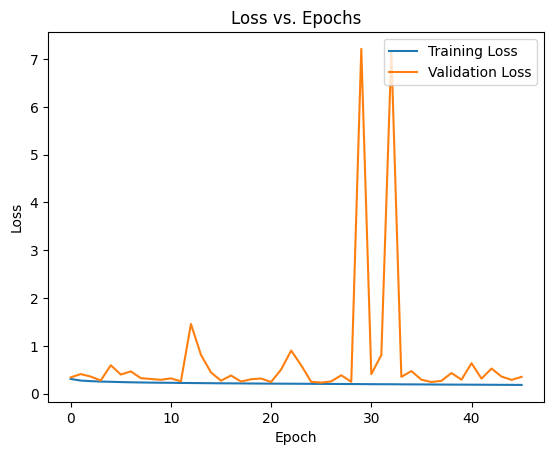

In [10]:
# Make a plot for the loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.show()

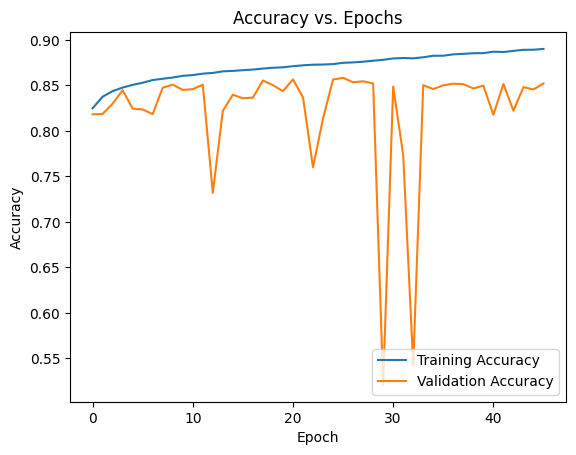

In [11]:
# Make a plot for the accuracy
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('Accuracy vs. Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.show()

## Evaluate the CNN

Get best model

In [13]:
# Load best model from file
model = tf.keras.models.load_model('CNNmodel')

Get test data (image partitions are derived from the 200th - 400th images of the dataset)

In [18]:
# Test data
X = {}
X['no'] = np.load(PATH + f"detector_npy/njpeg/noblockcnn400.npy")

X['single'] = {}
X['double'] = {}
for QF in range(10, 100, 20):
    X['single'][str(QF)] = np.load(
        PATH + f"detector_npy/sjpeg{QF}/singleblockcnn400.npy")
    X['double'][str(QF)] = np.load(
        PATH + f"detector_npy/djpeg50{QF}/doubleblockcnn400.npy")

Evaluate the test loss and accuracy for each compression type

In [19]:
# Evaluate the model

# no compression
y = np.array([0] * len(X['no']))
test_loss, test_acc = model.evaluate(X['no'], y, verbose=0)
print("No", test_loss, test_acc)

# single compression
y = np.array([1] * 50000)
for QF in range(10, 100, 20):
    test_loss, test_acc = model.evaluate(
        X['single'][str(QF)], y[:len(X['single'][str(QF)])], verbose=0)
    print("Single", QF, test_loss, test_acc)

# double compression
y = np.array([2] * 50000)
for QF in range(10, 100, 20):
    test_loss, test_acc = model.evaluate(
        X['double'][str(QF)], y[:len(X['double'][str(QF)])], verbose=0)
    print("Double", QF, test_loss, test_acc)

No 0.04243192449212074 0.9849989414215088
Single 10 0.9700430035591125 0.07696801424026489
Single 30 0.26640820503234863 0.8215762972831726
Single 50 0.843832790851593 0.360580176115036
Single 70 0.03444141522049904 0.9737831950187683
Single 90 0.021884148940443993 0.9847419261932373
Double 10 0.5223484635353088 0.951047956943512
Double 30 0.14202827215194702 0.9537584185600281
Double 50 0.4418136477470398 0.8585882186889648
Double 70 0.05280162766575813 0.9968456029891968
Double 90 0.0521143302321434 0.9980605840682983
